# Calculating default variables

In this notebook, we'll demonstrate how to calculate descriptor (variable) sets 1-4:

1. Canonical (UniProt) sequence variables.
2. Structure (PDB) sequence variables.
3. Structure variables (angles, distances, etc.)
4. Ligand variables.

and custom variables for domain sequences and structures.

In [1]:
import logging
import warnings
from random import sample
from pathlib import Path

from kinactive import DefaultFeatures, DB, DBConfig

## Setup

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
N_PROC = 15

BASE = Path('../data/variable_sets-test')
BASE.mkdir(exist_ok=True)

DB_PATH = Path('../data/lXt-PK-test/')

## Load the database

In [4]:
db = DB(DBConfig(io_cpus=N_PROC))
chains = db.load(DB_PATH, domains=True)

INFO:kinactive.db:Got 3 initial paths to read


Reading Chain: 0it [00:00, ?it/s]

INFO:kinactive.db:Parsed 3 `Chain`s


In [5]:
chains, len(chains.structures.drop_duplicates())

([Chain(PK_1|28-316)<-(Chain(tr|O96214|O96214_PLAFA|1-320)), Chain(PK_1|119-403)<-(Chain(sp|P49840|GSK3A_HUMAN|1-483)), Chain(PK_1|44-298)<-(Chain(sp|P00517|KAPCA_BOVIN|1-351))],
 104)

## Calculate default variables

In [6]:
vs = DefaultFeatures()
?vs.calculate_all_vs

Signature:
vs.calculate_all_vs(
    chains: collections.abc.Sequence[lXtractor.chain.chain.Chain],
    map_name: str = 'PK',
    num_proc: int = 1,
    verbose: bool = True,
    base: pathlib.Path | None = None,
    overwrite: bool = False,
) -> kinactive.features.Results
Docstring:
Calculate default variables. These include four sets::

    #. A default set of sequence variables for canonical sequences.
    #. A default set of sequence variables for structure sequences.
    #. A default set of structure variables.
    #. A default set of ligand variables.

:param chains: A sequence of chains.
:param map_name: A reference name.
:param num_proc: The number of CPUs to use.
:param verbose: Display progress bar.
:param base: Base path to save the results to. If not provided, the
    results are returned but not saved.
:param overwrite: Overwrite existing files. If False, will skip the
    calculation of existing variables.
:return: A named tuple with calculated variables' tables.
File:    

In [7]:
vs_res = vs.calculate_all_vs(
    chains, num_proc=N_PROC, base=BASE, overwrite=True
)

INFO:kinactive.features:Calculating sequence variables on canonical seqs


Calculating variables: 0it [00:00, ?it/s]

INFO:kinactive.features:Resulting shape: (3, 799)
INFO:kinactive.features:Saved defaults_can_seq_vs.csv to ../data/variable_sets-test
INFO:kinactive.features:Calculating sequence variables on structure seqs


Calculating variables: 0it [00:00, ?it/s]

INFO:kinactive.features:Resulting shape: (104, 799)
INFO:kinactive.features:Saved defaults_str_seq_vs.csv to ../data/variable_sets-test
INFO:kinactive.features:Calculating ligand variables


Calculating variables: 0it [00:00, ?it/s]

INFO:kinactive.features:Resulting shape: (104, 793)
INFO:kinactive.features:Saved default_lig_vs.csv to ../data/variable_sets-test
INFO:kinactive.features:Calculating structure variables


Calculating variables: 0it [00:00, ?it/s]

INFO:kinactive.features:Resulting shape: (104, 1693)
INFO:kinactive.features:Saved default_str_vs.csv to ../data/variable_sets-test
INFO:kinactive.features:Finished calculations


Calculating all four sets on all domains takes ~40min on 20 cores.

## Calculate specific variable set

If one needs a specific default variable set, the following code can be used

In [8]:
# Structure variables
vs_res = vs.calculate_str_vs(chains.structures[:5])

Calculating variables: 0it [00:00, ?it/s]

In [9]:
# Sequence variables
vs_res = vs.calculate_seq_vs(chains.sequences[:5])

Calculating variables: 0it [00:00, ?it/s]

In [10]:
vs_res.head()

,ObjectID,"SeqEl(p=30,_rtype='str',seq_name='seq1')","SeqEl(p=48,_rtype='str',seq_name='seq1')","SeqEl(p=140,_rtype='str',seq_name='seq1')","SeqEl(p=141,_rtype='str',seq_name='seq1')","SeqEl(p=142,_rtype='str',seq_name='seq1')","SeqEl(p=143,_rtype='str',seq_name='seq1')","PFP(p=1,i=1)","PFP(p=1,i=2)","PFP(p=1,i=3)",...,"PFP(p=261,i=3)","PFP(p=262,i=1)","PFP(p=262,i=2)","PFP(p=262,i=3)","PFP(p=263,i=1)","PFP(p=263,i=2)","PFP(p=263,i=3)","PFP(p=264,i=1)","PFP(p=264,i=2)","PFP(p=264,i=3)"
0,PK_1|28-316<-(tr|O96214|O96214_PLAFA|1-320),K,E,S,D,F,G,3.14,3.59,2.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PK_1|119-403<-(sp|P49840|GSK3A_HUMAN|1-483),K,E,C,D,F,G,3.14,3.59,2.45,...,1.2,-4.57,-2.55,-0.67,6.76,0.88,0.89,6.76,0.88,0.89
2,PK_1|44-298<-(sp|P00517|KAPCA_BOVIN|1-351),K,E,T,D,F,G,6.76,0.88,0.89,...,1.2,-4.99,5.00,0.70,7.33,4.55,2.77,6.76,0.88,0.89


## Calculate custom variables

One can define and calculate custom variables. They are handled by the [lXtractor package](https://lxtractor.readthedocs.io/en/latest/lXtractor.variables.html).

First, let's calculate the number of missing residues and the number of phosphotyrosines within the activation loop for each structure sequence.

In [11]:
from kinactive.features import calculate
import lXtractor.variables as lxv

In [12]:
def missing(numbering):
    """
    Count the number of non-consecutive elements in numbering.
    """
    ns = list(numbering)
    return [ns[i] != (ns[i - 1] + 1) for i in range(1, len(ns))]

In [13]:
vs = [
    lxv.make_str(
        reduce=sum, 
        transform=missing, 
        reduce_name='Count',
        rtype=int,
    )(143, 170, seq_name='numbering'),
]
vs

[SliceMissingCount(start=143,stop=170,step=None,seq_name='numbering')]

In [14]:
vs_res = calculate(
    chains.structure_sequences.drop_duplicates(), 
    vs, map_name='PK', seq_name='numbering'
)
len(vs_res[vs_res[vs[0].id] > 0])

Calculating variables: 0it [00:00, ?it/s]

0

In [15]:
vs = [
    lxv.make_str(
        reduce=sum, 
        transform=lambda xs: (x == 'PTR' for x in xs), 
        transform_name='isphosphotyr',
        reduce_name='count',
        rtype=int,
    )(143, 170, seq_name='seq3'),
]
vs

[SliceIsphosphotyrCount(start=143,stop=170,step=None,seq_name='seq3')]

In [16]:
vs_res = calculate(
    chains.structure_sequences.drop_duplicates(), 
    vs, map_name='PK', seq_name='seq3'
)
vs_res[vs_res[vs[0].id] > 0]

Calculating variables: 0it [00:00, ?it/s]

,ObjectID,"SliceIsphosphotyrCount(start=143,stop=170,step=None,seq_name='seq3')"
1,PK_1|19-298<-(7SXF:A|1-340),1
2,PK_1|14-292<-(7SXG:A|1-334),1


Let's also calculate the distance between CB atoms of the DFG-Phe and beta-3 Lys and plot the obtained distribution.

In [17]:
vs = [
    lxv.Dist(30, 52, 'CB', 'CB')
]
vs

[Dist(p1=30,p2=52,a1='CB',a2='CB',com=False)]

Calculating variables: 0it [00:00, ?it/s]

<Axes: >

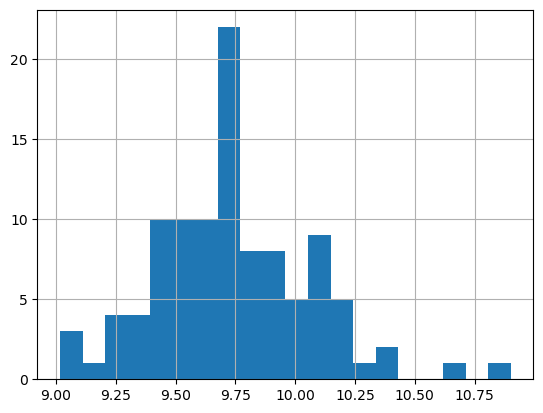

In [18]:
vs_res = calculate(
    chains.structures.drop_duplicates(), 
    vs, map_name='PK', seq_name='seq3'
)
vs_res[vs[0].id].hist(bins=20)